In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt

from mne import read_epochs, set_log_level, compute_rank, concatenate_epochs

from scipy.stats import kurtosis, skew, moment, entropy, norm
from mne.decoding import CSP, Scaler
from mne import EpochsArray
from mrmr import mrmr_classif
from random import randint
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Covariances, Kernels
from mne.time_frequency import tfr_multitaper, tfr_morlet
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, GridSearchCV,ShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif').pick('eeg').filter(0,240)
epochs.drop_channels(epochs.info['bads'])
epochs.apply_baseline((-1.4,-0.4))
print()

In [3]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
linear_svm = svm.SVR(kernel="linear")
le = LabelEncoder()
scaler = Scaler(info=epochs.info)

In [4]:
def dwt_det_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return det

def dwt_aprox_coeff(x, db='db2'):
    aprx, det = pywt.dwt(x,db)
    return aprx

def rms(x):
    return np.sqrt(np.mean(x**2))

def slope(x):
    t = np.linspace(0, len(x)-1, len(x))
    return np.polyfit(t, x, 1)[0]

def autocorr(x):
    return float(np.correlate(x,x))
    
def temp_centroid(x):
    nom = [x[i] * i for i in range(x.shape[0])]
    return sum(nom)/sum(x)

def energy(x):
    return sum(x**2)

def med_abs_diff(x):
    return np.median(np.abs(np.diff(x)))

def mean_abs_diff(x):
    return np.mean(np.abs(np.diff(x)))

def calc_centroid(x, fs=1024):
    energy = np.array(x) ** 2
    t = range(len(x))
    t = [float(x) / fs for x in t]
    t_energy = np.dot(np.array(t), np.array(energy))
    energy_sum = np.sum(energy)

    if energy_sum == 0 or t_energy == 0:
        centroid = 0
    else:
        centroid = t_energy / energy_sum

    return centroid

In [5]:
broca = ['F7','F5','F3','F1','FC5','FC3','FC1']
temp = ['FT7', 'T7', 'TP7','C5','CP5']
wernicke = ['P3','P1','Pz','P7']
right_rg = ['F8','F6','F4','F2','FC6','FC4','FC2', 'FTC6', 'T8', 'TP8','C6','CP4','CPz','C2','C4']


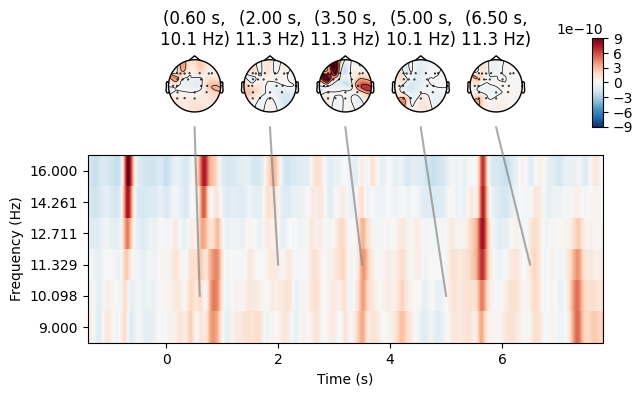

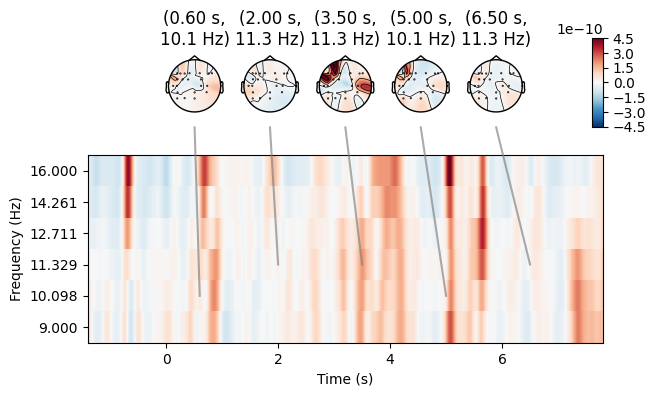

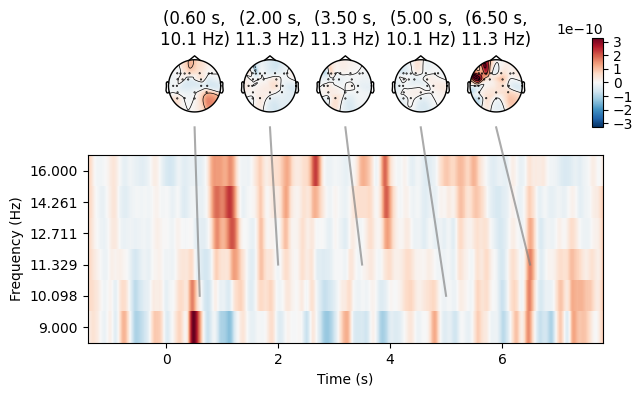

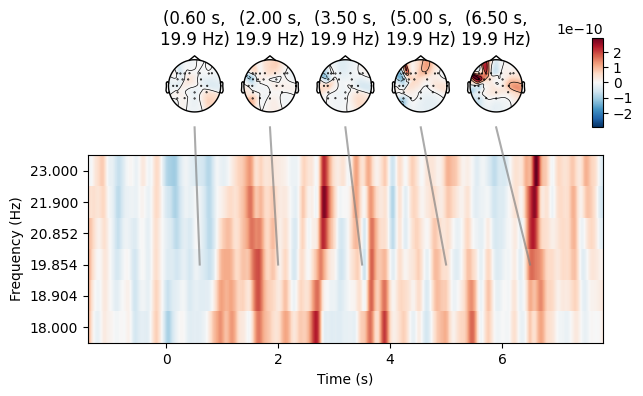

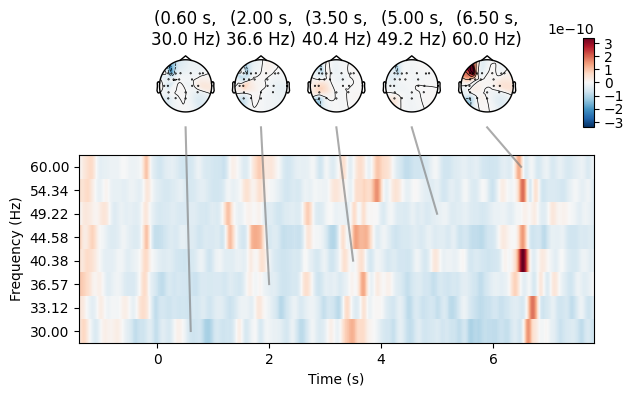

In [6]:
rep_epochs = epochs['r_pinch', 'r_stop'].copy()
freqs = np.logspace(*np.log10([9, 16]), num=6)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    epochs['rest'].pick(broca+temp+wernicke+right_rg),
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)
power.plot_joint(
    baseline=(-1.4,-.4), 
    mode="mean", tmin=-1.4, tmax=7.8, 
    timefreqs=[(.6, 10), (2, 12), (3.5, 12), (5, 10), (6.5, 12)])

freqs = np.logspace(*np.log10([9, 16]), num=6)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    epochs['left','rest'].pick(broca+temp+wernicke+right_rg),
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)
power.plot_joint(
    baseline=(-1.4,-.4), 
    mode="mean", tmin=-1.4, tmax=7.8, 
    timefreqs=[(.6, 10), (2, 12), (3.5, 12), (5, 10), (6.5, 12)])

power, itc = tfr_morlet(
    rep_epochs.pick(broca+temp+wernicke+right_rg),
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)
power.plot_joint(
    baseline=(-1.4,-.4), 
    mode="mean", tmin=-1.4, tmax=7.8, 
    timefreqs=[(.6, 10), (2, 12), (3.5, 12), (5, 10), (6.5, 12)])

freqs = np.logspace(*np.log10([18, 23]), num=6)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    rep_epochs.pick(broca+temp+wernicke+right_rg),
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)
power.plot_joint(
    baseline=(-1.4,-.4), 
    mode="mean", tmin=-1.4, tmax=7.8, 
    timefreqs=[(.6, 20), (2, 20), (3.5, 20), (5, 20), (6.5, 20)])

freqs = np.logspace(*np.log10([30, 60]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    rep_epochs.pick(broca+temp+wernicke+right_rg),
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)
power.plot_joint(
    baseline=(-1.4,-.4), 
    mode="mean", tmin=-1.4, tmax=7.8,
    timefreqs=[(.6, 30), (2, 35), (3.5, 40), (5, 50), (6.5, 60)]
)

print()


 Left vs Rest

In [9]:
conditions = ['r_pinch', 'rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
subset_rest = subset['rest'].copy().crop(0.1,3.8).get_data()
subset_rest = EpochsArray(subset_rest, subset['rest'].info, events=subset['rest'].events, event_id=epochs['rest'].event_id)
subset_img = subset['r_pinch'].copy().crop(4.1,7.8).get_data()
subset_img = EpochsArray(subset_img, subset['r_pinch'].info, events=subset['r_pinch'].events, event_id=epochs['r_pinch'].event_id)

subset = concatenate_epochs([subset_img, subset_rest])
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().get_data()    


In [11]:
selected_fts = get_informative_features('bior5.5', 1, 6, 'lda')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.57it/s]


mean accuracy:  0.8946428571428573


Left vs Right

In [6]:
conditions = ['r_pinch', 'r_stop']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().crop(4.1,7.8).get_data()    

In [7]:
selected_fts = get_informative_features('db4', 3, 4, 'lda')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


mean accuracy:  0.8777777777777777


 3 class

In [14]:
subset = epochs.copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
subset_rest = subset['rest'].copy().crop(0.1,3.8).get_data()
subset_rest = EpochsArray(subset_rest, subset['rest'].info, events=subset['rest'].events, event_id=epochs['rest'].event_id)
subset_img = subset['r_pinch'].copy().crop(4.1,7.8).get_data()
subset_img = EpochsArray(subset_img, subset['r_pinch'].info, events=subset['r_pinch'].events, event_id=epochs['r_pinch'].event_id)
subset_img1 = subset['r_stop'].copy().crop(4.1,7.8).get_data()
subset_img1 = EpochsArray(subset_img1, subset['r_stop'].info, events=subset['r_stop'].events, event_id=epochs['r_stop'].event_id)


subset = concatenate_epochs([subset_img, subset_rest, subset_img1])
y = le.fit_transform(subset.events[:,2])
train_data = subset.copy().get_data()    

In [15]:
selected_fts = get_informative_features('bior3.5', 1, 3, 'lda',21)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.05it/s]


mean accuracy:  0.7602564102564102


In [12]:
conditions = ['left', 'right', 'rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
chance = np.max([np.mean(y == y[0]), np.mean(y == y[1]), np.mean(y == y[2])])
train_data = subset.copy().crop(.2,1.2).get_data()    

print(genConf(train_data.shape[0], 0.01))
print(genConf(train_data.shape[0], 0.05))

56.785562549087665
52.37092489152947


In [15]:
selected_fts = get_informative_features('bior3.5', 1, 3, 'lda', 25)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.60it/s]


mean accuracy:  0.7714285714285714


In [13]:
selected_fts = get_informative_features('bior3.5', 1, 3, 'lda', 21)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.41s/it]


mean accuracy:  0.7357142857142857


In [7]:
def get_informative_features(db, lvl, lvl1, classifier, features=10):
    score = []
    ft_names = get_feature_names(lvl,lvl1) 
    selected_features = []
    detail_coeffs, aprox_coeffs = get_coeffs(db, lvl, lvl1) 
    for train_rep in range(10):  
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=25+train_rep)        
        cv_split = cv.split(detail_coeffs[lvl], y)
        
        mrmr_features = None  
        median_score = []
        for train_idx, test_idx in cv_split:
            y_train, y_test = y[train_idx], y[test_idx]  

            x_train, x_test = get_feature_vector(detail_coeffs, aprox_coeffs, lvl, lvl1, train_idx, test_idx)

            if classifier == 'svm':
                estimator = svm_rbf
            elif classifier == 'lda':
                estimator = lda
            elif classifier == 'rf':
                estimator = rf
            elif classifier == 'knn':
                estimator = knn

            if mrmr_features is None:            
                x_pd = pd.DataFrame(x_train)
                mrmr_features = mrmr_classif(X=x_pd, y=y_train, K=features)
                
            x_train =  x_train[:,mrmr_features]
            x_test = x_test[:,mrmr_features]

            estimator.fit(x_train, y_train)
            median_score.append(np.median(estimator.score(x_test, y_test)))
            
        selected_features.append(np.array(ft_names)[mrmr_features])
        score.append(np.median(median_score))
        
    print('mean accuracy: ',np.mean(score))
    return selected_features

def get_coeffs(db, lvl, lvl1): 
    x_aprox_coeff = train_data
          
    detail_coeffs = []
    aprox_coeffs = []
    for dwt_lvl in range(lvl1+1):
        x_det_coeff = np.apply_along_axis(dwt_det_coeff, 2, x_aprox_coeff, db=db)
        x_aprox_coeff = np.apply_along_axis(dwt_aprox_coeff, 2, x_aprox_coeff, db=db)

        detail_coeffs.append(scaler.fit_transform(x_det_coeff.copy(),y))
        aprox_coeffs.append(scaler.fit_transform(x_aprox_coeff.copy(),y))
    
    return detail_coeffs, aprox_coeffs

def get_feature_vector(detail_coeffs, aprox_coeffs, lvl, lvl1, train_idx, test_idx):
    x_train = []
    
    x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl][train_idx]))

    x_train.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1][train_idx]))

    x_train.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1][train_idx]**2))
    x_train.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1][train_idx]))
    x_train.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1][train_idx]))

    x_train = np.concatenate(x_train, axis=1)

    x_test = []

    x_test.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl][test_idx]))

    x_test.append(np.apply_along_axis(np.std, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, detail_coeffs[lvl1][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, detail_coeffs[lvl1][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, detail_coeffs[lvl1][test_idx]))

    x_test.append(np.apply_along_axis(np.std, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.max, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.min, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(rms, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(slope, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(skew, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(np.average, 2, aprox_coeffs[-1][test_idx]**2))
    x_test.append(np.apply_along_axis(mean_abs_diff, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(temp_centroid, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(energy, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(kurtosis, 2, aprox_coeffs[-1][test_idx]))
    x_test.append(np.apply_along_axis(calc_centroid, 2, aprox_coeffs[-1][test_idx]))

    x_test = np.concatenate(x_test, axis=1)

    return x_train, x_test

def get_feature_names(lvl, lvl1):
    all_features = []
    signal_features = ['std', 'max', 'min', 'rms', 'slope', 'skew', 'avg', 'mean_abs','temp_centr','enrgy','krts','st_centr']
    
    for level in range(3):
        for ft in signal_features:
            for ch in subset.info['chs']:
                if level == 0:
                    all_features.append('D'+str(lvl) + '_' + ch['ch_name'] + '_' + ft)
                elif level == 1:
                    all_features.append('D'+str(lvl1) + '_' + ch['ch_name'] + '_' + ft)
                else :
                    all_features.append('A0'+ '_' + ch['ch_name'] + '_' + ft)
                    
    return all_features 


In [10]:
# compute conf level
def p(n):
    return (n*chance+2)/(n+4)
def conf(n,p,alpha):
    return np.sqrt((p*(1-p))/(n+4))*norm.ppf(1-(alpha/2))
def genConf(n, alpha):
    res = np.zeros((n))
    for i in range(0,n):
        res[i] = p(i) + conf(i, p(i), alpha)
    return res[-1]*100